In [ ]:
!pip install transformers datasets rouge-score nltk torch optuna bert-score


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from datasets import load_dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from rouge_score import rouge_scorer
from torch.utils.data import DataLoader
from torch import nn
import torch
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score
from nltk.translate.meteor_score import meteor_score
import optuna
import os
import matplotlib.pyplot as plt

# Necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


/home/desai226/.local/lib/python3.9/site-packages/transformers/loss/loss_for_object_detection.py:28: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.2)
  from scipy.optimize import linear_sum_assignment


Using device: cuda


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/desai226/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/desai226/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
t5_model_name = 't5-base'
print(f"Loading T5 model: {t5_model_name}")
tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
model = T5ForConditionalGeneration.from_pretrained(t5_model_name).to(device)

# Initializing lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading T5 model: t5-base


In [ ]:
# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    return ' '.join(words)

# Function to remove rows with missing data
def remove_missing_data(dataset, columns):
    return dataset.filter(lambda x: all(x[col] is not None for col in columns))

# Function to load and clean dataset
def load_and_clean_data():
    train_data = load_dataset("ragha92/FNS_Summarization", split="train")
    validation_data = load_dataset("ragha92/FNS_Summarization", split="validation")
    test_data = load_dataset("ragha92/FNS_Summarization", split="test")

    columns = ['Annual Reports', 'Gold Summaries']
    train_data = remove_missing_data(train_data, columns)
    validation_data = remove_missing_data(validation_data, columns)
    test_data = remove_missing_data(test_data, columns)

    return train_data, validation_data, test_data

train_data, validation_data, test_data = load_and_clean_data()
print("Datasets loaded and cleaned.")


Datasets loaded and cleaned.


In [ ]:
# Function for suggesting best hyperparameters
def objective(trial):

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    num_beams = trial.suggest_int('num_beams', 2, 10)
    length_penalty = trial.suggest_uniform('length_penalty', 0.5, 2.0)
    max_length = trial.suggest_int('max_length', 256, 1024, step=64)  # Increment of 64
    min_length = trial.suggest_int('min_length', 50, 300, step=50)    # Increment of 50

    # Ensuring min_length is always less than max_length
    if min_length >= max_length:
        return float('inf')

    # Model and optimizer
    model.train()
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=2, shuffle=True)

    # Training for one epoch
    total_loss = 0
    for batch_idx, batch in enumerate(dataloader):
        optimizer.zero_grad()
        input_texts = batch['Annual Reports']
        target_summaries = batch['Gold Summaries']

        inputs = tokenizer(input_texts, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)
        targets = tokenizer(target_summaries, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)

        outputs = model(input_ids=inputs['input_ids'], labels=targets['input_ids'])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss  # Optuna minimizes this value

# Optuna study - run
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Displaying best parameters
print("Best Hyperparameters:")
print(study.best_params)

[I 2024-11-28 08:27:49,567] A new study created in memory with name: no-name-846815cd-571c-4e4e-8434-717c443d4104
/tmp/ipykernel_4493/4092587985.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
/tmp/ipykernel_4493/4092587985.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  length_penalty = trial.suggest_uniform('length_penalty', 0.5, 2.0)
/home/desai226/.local/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` t

Best Hyperparameters:
{'learning_rate': 0.00024891242378186854, 'num_beams': 7, 'length_penalty': 1.55871543453282, 'max_length': 896, 'min_length': 50}


In [ ]:
# Summarization function for T5 with dynamic hyperparameters
def summarize_text_t5(article, num_beams=3, length_penalty=1.5, max_length=512, min_length=200):
    input_text = f"summarize: {article}"
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True).to(device)
    summary_ids = model.generate(
        input_ids,
        max_length=max_length,
        min_length=min_length,
        length_penalty=length_penalty,
        num_beams=num_beams,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


In [ ]:
# Fine-tuning the T5 model
def fine_tune_model(train_data, epochs=3, learning_rate=5e-5):
    model.train()
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    dataloader = DataLoader(train_data, batch_size=2, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, batch in enumerate(dataloader):
            optimizer.zero_grad()
            input_texts = batch['Annual Reports']
            target_summaries = batch['Gold Summaries']

            # Tokenizing inputs and targets
            inputs = tokenizer(input_texts, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)
            targets = tokenizer(target_summaries, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)

            # Forward pass and loss computation
            outputs = model(input_ids=inputs['input_ids'], labels=targets['input_ids'])
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader)}")

# Fine-tuning with best hyperparameters
best_params = study.best_params
fine_tune_model(train_data, epochs=3, learning_rate=best_params['learning_rate'])

Epoch 1/3, Loss: 2.1633788719556284
Epoch 2/3, Loss: 2.042620621017605
Epoch 3/3, Loss: 1.954828323362377


In [ ]:
# Model Evaluation function
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize

def evaluate_model_extended(dataset):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': [], 'bleu': [], 'meteor': [], 'bertscore': []}
    smooth = SmoothingFunction().method4

    references = []
    candidates = []

    for item in dataset:
        article = preprocess_text(item['Annual Reports'])
        gold_summary = preprocess_text(item['Gold Summaries'])
        if article:
            generated_summary = summarize_text_t5(
                article,
                num_beams=best_num_beams,
                length_penalty=best_length_penalty,
                max_length=best_max_length,
                min_length=best_min_length
            )
            references.append(gold_summary)
            candidates.append(generated_summary)

            # ROUGE and BLEU
            score_rouge = scorer.score(gold_summary, generated_summary)
            scores['rouge1'].append(score_rouge['rouge1'].fmeasure)
            scores['rouge2'].append(score_rouge['rouge2'].fmeasure)
            scores['rougeL'].append(score_rouge['rougeL'].fmeasure)
            bleu_score = sentence_bleu([gold_summary.split()], generated_summary.split(), smoothing_function=smooth)
            scores['bleu'].append(bleu_score)

            # Tokenizing summaries for METEOR
            tokenized_gold_summary = word_tokenize(gold_summary)
            tokenized_generated_summary = word_tokenize(generated_summary)

            # METEOR score
            meteor = meteor_score([tokenized_gold_summary], tokenized_generated_summary)
            scores['meteor'].append(meteor)

    # BERTScore
    P, R, F1 = score(candidates, references, lang="en", verbose=True)
    scores['bertscore'] = F1.numpy().tolist()

    avg_rouge1 = sum(scores['rouge1']) / len(scores['rouge1'])
    avg_rouge2 = sum(scores['rouge2']) / len(scores['rouge2'])
    avg_rougeL = sum(scores['rougeL']) / len(scores['rougeL'])
    avg_bleu = sum(scores['bleu']) / len(scores['bleu'])
    avg_meteor = sum(scores['meteor']) / len(scores['meteor'])
    avg_bertscore = sum(scores['bertscore']) / len(scores['bertscore'])

    return avg_rouge1, avg_rouge2, avg_rougeL, avg_bleu, avg_meteor, avg_bertscore

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/9 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/5 [00:00<?, ?it/s]

done in 7.98 seconds, 32.20 sentences/sec


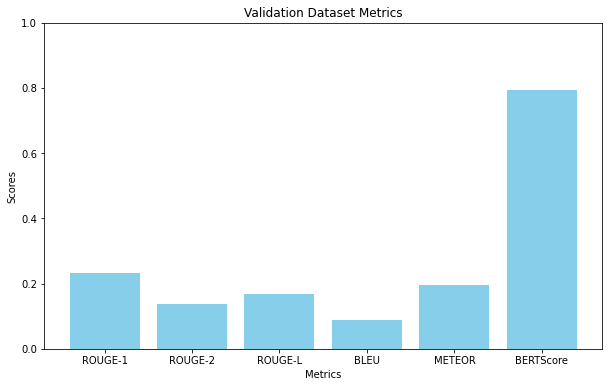

In [ ]:
# Function for visualizing metrics
def visualize_metrics(metrics, metric_names, dataset_type="Validation"):
    plt.figure(figsize=(10, 6))
    plt.bar(metric_names, metrics, color='skyblue')
    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.title(f'{dataset_type} Dataset Metrics')
    plt.ylim(0, 1)
    plt.show()

# Evaluate on Validation Set
val_metrics = evaluate_model_extended(validation_data)
val_metric_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BLEU', 'METEOR', 'BERTScore']
visualize_metrics(val_metrics, val_metric_names, dataset_type="Validation")

# Evaluate on Test Set
test_metrics = evaluate_model_extended(test_data)
visualize_metrics(test_metrics, val_metric_names, dataset_type="Test")


In [ ]:
print(val_metrics)

(0.23326167896268232, 0.1371677934238151, 0.16676282209772705, 0.08977264081832471, 0.19612197396982378, 0.7921500894809975)


In [ ]:
import pandas as pd

df = pd.DataFrame({'Metric': val_metric_names, 'Value': val_metrics})
print(df)

      Metric     Value
0    ROUGE-1  0.233262
1    ROUGE-2  0.137168
2    ROUGE-L  0.166763
3       BLEU  0.089773
4     METEOR  0.196122
5  BERTScore  0.792150


In [ ]:
print(test_metrics)

(0.2129687600549729, 0.10957890966571285, 0.1393401566006806, 0.06229641807327919, 0.16983919148222557, 0.7880433781601576)


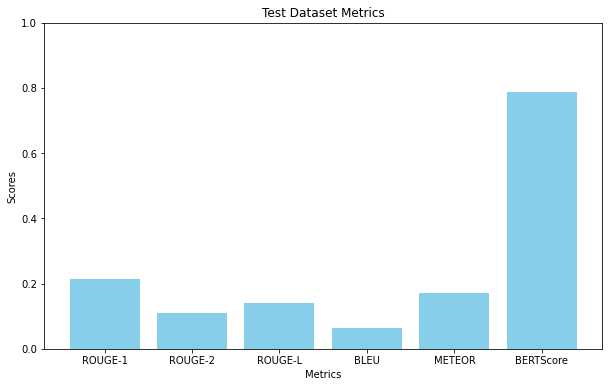

In [ ]:
visualize_metrics(test_metrics, val_metric_names, dataset_type="Test")

In [ ]:
import pandas as pd

df = pd.DataFrame({'Metric': val_metric_names, 'Value': test_metrics})
print(df)

      Metric     Value
0    ROUGE-1  0.212969
1    ROUGE-2  0.109579
2    ROUGE-L  0.139340
3       BLEU  0.062296
4     METEOR  0.169839
5  BERTScore  0.788043
